## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Reading the dataset

In [ ]:
df = pd.read_csv('TCS.csv')
df.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,TCS,EQ,26-Dec-2018,1918.50,1921.8,1921.8,1870.25,1892.00,1889.20,1884.77,2446614,4.611298e+09,97165,1206484,49.31
1,TCS,EQ,27-Dec-2018,1889.20,1909.0,1941.7,1872.10,1909.10,1908.95,1920.44,4968201,9.541146e+09,143656,1869270,37.62
2,TCS,EQ,28-Dec-2018,1908.95,1915.0,1920.0,1893.00,1897.00,1896.05,1907.36,2239130,4.270838e+09,112230,1238176,55.30
3,TCS,EQ,31-Dec-2018,1896.05,1908.0,1909.0,1886.15,1894.75,1893.05,1896.42,1879740,3.564772e+09,66284,1025862,54.57
4,TCS,EQ,01-Jan-2019,1893.05,1896.0,1910.0,1885.00,1905.90,1902.80,1899.78,1094883,2.080034e+09,32636,489139,44.68


## Analyzing the closing price

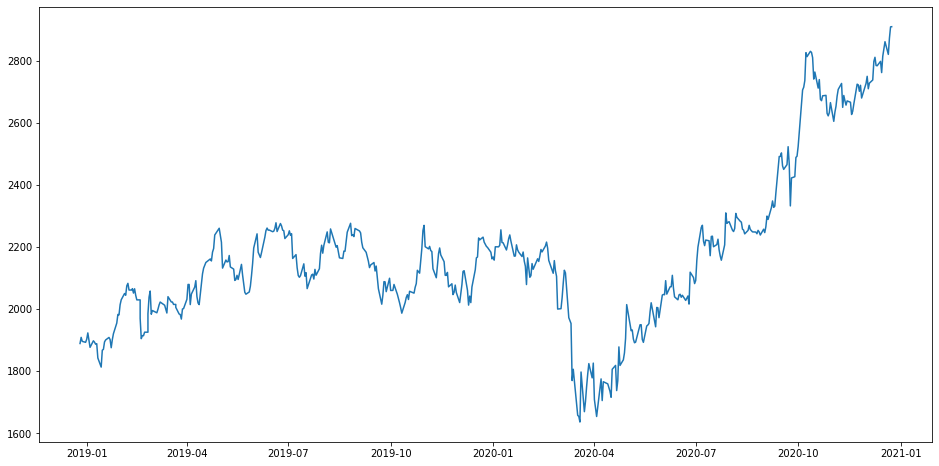

In [ ]:
df["Date"]=pd.to_datetime(df.Date)
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close Price"],label='Close Price history')

## Creating a new dataset with just "Date" and "Closing Price"

In [ ]:
df2 = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(len(df)):
  df2['Date'][i] = str(df['Date'][i]).split()[0]
  df2['Close'][i] = df['Close Price'][i]
df2.shape

(501, 2)

## Normalize the new dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
training_set = df2['Close']
training_set = pd.DataFrame(training_set)

scaled_training_set = scaler.fit_transform(training_set)

In [ ]:
X_train, y_train = [], []

for i in range(60, len(training_set)):
  X_train.append(scaled_training_set[i-60:i, 0])
  y_train.append(scaled_training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Build and train the LSTM model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
model = Sequential()

In [ ]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
11/11 [==============================] - 4s 58ms/step - loss: 0.2959 - accuracy: 0.0000e+00
Epoch 2/100
11/11 [==============================] - 1s 60ms/step - loss: 0.0345 - accuracy: 0.0027
Epoch 3/100
11/11 [==============================] - 1s 60ms/step - loss: 0.0208 - accuracy: 0.0027
Epoch 4/100
11/11 [==============================] - 1s 60ms/step - loss: 0.0187 - accuracy: 0.0017
Epoch 5/100
11/11 [==============================] - 1s 61ms/step - loss: 0.0142 - accuracy: 0.0010
Epoch 6/100
11/11 [==============================] - 1s 61ms/step - loss: 0.0147 - accuracy: 0.0027
Epoch 7/100
11/11 [==============================] - 1s 62ms/step - loss: 0.0135 - accuracy: 0.0042
Epoch 8/100
11/11 [==============================] - 1s 61ms/step - loss: 0.0121 - accuracy: 0.0069
Epoch 9/100
11/11 [==============================] - 1s 67ms/step - loss: 0.0112 - accuracy: 0.0092
Epoch 10/100
11/11 [==============================] - 1s 61ms/step - loss: 0.0179 - accuracy: 0.

In [ ]:
model.save('stock_price_prediction.model')

INFO:tensorflow:Assets written to: stock_price_prediction.model/assets


INFO:tensorflow:Assets written to: stock_price_prediction.model/assets


## Testing

In [ ]:
test_data = df2['Close'][400:]

inputs_data = df2['Close'][len(df2)-len(test_data)-60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

In [ ]:
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_closing_price = model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

## Visualizing predicted price

           Date    Close  Predictions
400  2020-08-04   2249.7  2245.918945
401  2020-08-05   2259.5  2237.169922
402  2020-08-06   2308.1  2245.771729
403  2020-08-07  2295.35  2287.220459
404  2020-08-10   2282.8  2286.062744


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


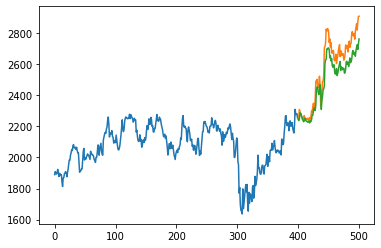

In [ ]:
train_data = df2[:400]
valid_data = df2[400:]
valid_data['Predictions'] = predicted_closing_price

print(valid_data.head())

plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])
